# Podcasts Reviews Inferential Statistical Analysis

## Introduction

The **aim** of this work is to analyze database of Podcasts Reviews and find useful insights which could help business with creating new podcasts. 

We will check for anomalies, correlations and other relations between features. We will perform statistical inference, form hypotheses base by what we find.


The work **objectives** are as follows:
<ul>
    <li>Find most and least popular podcasts categories.</li>
    <li>Check how reviews numbers impact ratings.</li>
    <li>Find the best time in the year to start podcasts.</li>
</ul>

**Database structure**:

1. categories - podcast_id, category
2. podcasts - podcast_id, itunes_id, slug, itunes_url, title
3. reviews - podcast_id, title, content, rating, author_id, created_ad
4. runs - run_at, max_rowid, reviews_added

Database filled with over 2 million reviews and more than 100 thousands podcasts.
However, in this work only a part of the available resources is used.

## Notebook Preparation

Import necessary libraries for analysis. Set default parameters for charts.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import math
import sqlite3

from helpers import helpers

custom_parameters = {"figure.figsize": (10, 6)}
custom_palette = sns.color_palette("Blues_r")

sns.set_theme(rc=custom_parameters)
sns.set_palette(custom_palette)
sns.set_style("whitegrid")

%matplotlib inline

In [2]:
def sql_query(query):
    """
    Return dataframe of sql query
    
    :param query: SQL Query code
    :return: Dataframe also show Row and Column number
    """
    cur = con.cursor()
    cur.execute(query)
    column_name = [c[0] for c in cur.description]
    df = pd.DataFrame(cur.fetchall(), columns=column_name)
    cur.close()  # Close connection

    return df

Download the database from [Kaggle](https://www.kaggle.com/datasets/thoughtvector/podcastreviews/versions/28?resource=download). If you don't have it put it in desire folder and change the path in equivalent way provided below.

In [3]:
con = sqlite3.connect("data/database.sqlite")

## Data Cleaning

First step before moving forward is to check data quality. For this we will perform some data cleaning steps fixing dtypes, cleaning for duplicates, etc. We will create some dummy dataframes to evaluate tables quality for future analysis.

### Categories

Load **categories** table to dataframe and check if it have any missing values or duplicates.

In [4]:
df_dummy = sql_query("SELECT * FROM categories")

In [5]:
df_dummy.duplicated().any()

False

In [6]:
df_dummy.isnull().any()

podcast_id    False
category      False
dtype: bool

#### Categories Summary
<ul>
    <li>Categories table don't have any duplicates or missing values.</li>
</ul>

### Podcasts

Now let's check podcasts table.

In [7]:
df_dummy = sql_query("SELECT * FROM podcasts")

In [8]:
df_dummy.duplicated().any()

False

In [9]:
df_dummy.isnull().any()

podcast_id    False
itunes_id     False
slug          False
itunes_url    False
title         False
dtype: bool

#### Podcasts Summary
<ul>
    <li>Podcasts table don't have any duplicates or missing values.</li>
</ul>

### Reviews

Next table is **reviews**.

In [10]:
df_dummy = sql_query("SELECT * FROM reviews")

In [11]:
df_dummy[df_dummy.duplicated()].sort_values(by=["created_at"])

,podcast_id,title,content,rating,author_id,created_at
499918,cc99f4b0e47185ff334465bdfaab02a2,Lacking insight,Although I find the topics of his podcasts int...,2,C0650E7918DC2D0,2013-09-24T07:02:59-07:00
499905,cc99f4b0e47185ff334465bdfaab02a2,Lacking insight,Although I find the topics of his podcasts int...,2,C0650E7918DC2D0,2013-09-24T07:02:59-07:00
41238,fc872e2f9ccb06545610131e63913836,Thanks for the amazing month!,You are a mesmerizing storyteller. I am in aww...,5,2D5A9CAD42B8852,2013-10-07T17:11:52-07:00
752638,e0a0316917ac3c1ad826f182665dfb87,Love his style,Love this guy. He shares SO much info. Some o...,5,5F5F7C02657E564,2013-10-08T15:04:49-07:00
205463,da220feb65a81baa329227e0bf26ce21,Feels like home,Listening to these guys remind me of me sittin...,5,98FA7EC83BD0609,2013-10-31T11:10:35-07:00
...,...,...,...,...,...,...
1956830,a0dcc13fd50bb25c866a8b9a2eca0f50,Racist,Continues to mispronounce foreign golfer’s nam...,1,3A41905452F889F,2022-07-26T03:52:22-07:00
1946650,ae97c70120af155f0813f5fba880e60a,"“Chyna,Chyna,Chyna..”",The Biden administration is bought and paid fo...,5,1079EE1C386A625,2022-08-07T16:11:20-07:00
2038031,d932c422cf9912aaf2dda5d85db16bc5,The golden rule😎,Teacher:Remember the golden rule kids! Kid: “...,5,DEE40F896231EF1,2022-12-27T19:30:37-07:00
2061745,b8dd9da8109547f36042ef7d14baeeb6,"Love It!, But Not enough LGBTQ+ Representation",PLEASE DO A STORY ABOUT SOMEONE FROM THE LGBTQ...,5,62EF1D9E8B948E6,2023-01-30T09:09:29-07:00


We see that we have 655 duplicates in our table, we will take a note to remove them when we will do some aggregation with this table. Now also check for any missing values.

In [12]:
df_dummy.isnull().any()

podcast_id    False
title         False
content       False
rating        False
author_id     False
created_at    False
dtype: bool

In [13]:
df_dummy = sql_query("SELECT date(created_at) AS date FROM reviews")

In [14]:
df_dummy.isnull().sum()

date    2
dtype: int64

#### Reviews summary
<ul>
    <li>Table have 655 rows of duplicates, we will not use them in further analysis.</li>
    <li>We don't find any missing values.</li>
    <li>Converting created_at column to date we found out that not all values are valid. 2 of them was not in date time format, so we will note it when we use this column.</li>
</ul>

### Runs

Last table to check is **runs**.

In [15]:
df_dummy = sql_query("SELECT * FROM runs")

In [16]:
df_dummy.duplicated().any()

False

In [17]:
df_dummy.isnull().any()

run_at           False
max_rowid        False
reviews_added    False
dtype: bool

In [18]:
del df_dummy # clean mem

#### Runs Summary
<ul>
    <li>Runs table don't have any duplicates or missing values.</li>
</ul>

## Exploratory data analysis

As we done cleaning our data we can proceed further and dive deeper to our data. We can start by exploring categories dataset.

### Podcasts distribution over categories

In [19]:
df_categories = sql_query("""
SELECT 
    category , 
    COUNT() AS num_of_podcasts
FROM categories
GROUP BY category
ORDER BY category ASC
""")

Category column have not only one type of category but sub categories. That's means one podcasts can have not only main category but also sub categories and vise versa.

In [20]:
unique_root_categories = []
other_categories = []

# Create a set to store roots already encountered
encountered_roots = set()

# Iterate over the categories
for category in df_categories["category"]:
    root = category.split('-')[0]  # Extract the root
    if root not in encountered_roots:
        unique_root_categories.append(
            category)  # Add to unique root categories
        encountered_roots.add(root)  # Add to encountered roots set
    else:
        other_categories.append(category)  # Add to other categories

In [21]:
print(f"In our database we have {len(unique_root_categories)} \
categories and {len(other_categories)} sub categories.")

In our database we have 25 categories and 85 sub categories.


In [22]:
# Get only main categories
df_categories_top = df_categories[df_categories["category"].isin(
    unique_root_categories)]
df_categories_top = df_categories_top.sort_values("num_of_podcasts",
                                                  ascending=False)

Text(0.5, 1.0, 'Podcasts Distribution Over Categories')

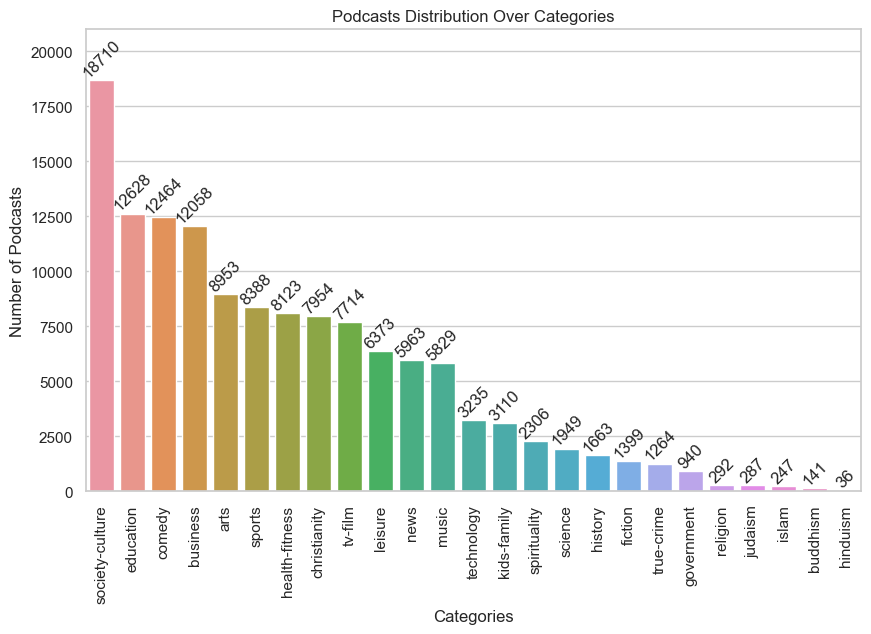

In [23]:
ax = sns.barplot(
    data=df_categories_top, 
    x="category", 
    y="num_of_podcasts")

ax.bar_label(
    ax.containers[0], 
    rotation=45)

plt.ylim(0, 21000)
plt.xticks(rotation=90)
plt.xlabel("Categories")
plt.ylabel("Number of Podcasts")
plt.title("Podcasts Distribution Over Categories")

We took all main categories from podcasts, and we already can see some key aspects. Picking category as type of religion is not very popular by numbers of podcasts there are not much of these podcasts overall. In other hand more entertainment like society-culture, education, arts, sport tend to have more podcasts numbers. 

Now let's check if the distribution over sub categories are similar. First we will check most popular and later least popular sub categories.

In [24]:
# Get all sub categories
df_categories_sub = df_categories[
    df_categories["category"].isin(
        other_categories)]

df_categories_sub = df_categories_sub.sort_values(
    "num_of_podcasts", 
    ascending=False)

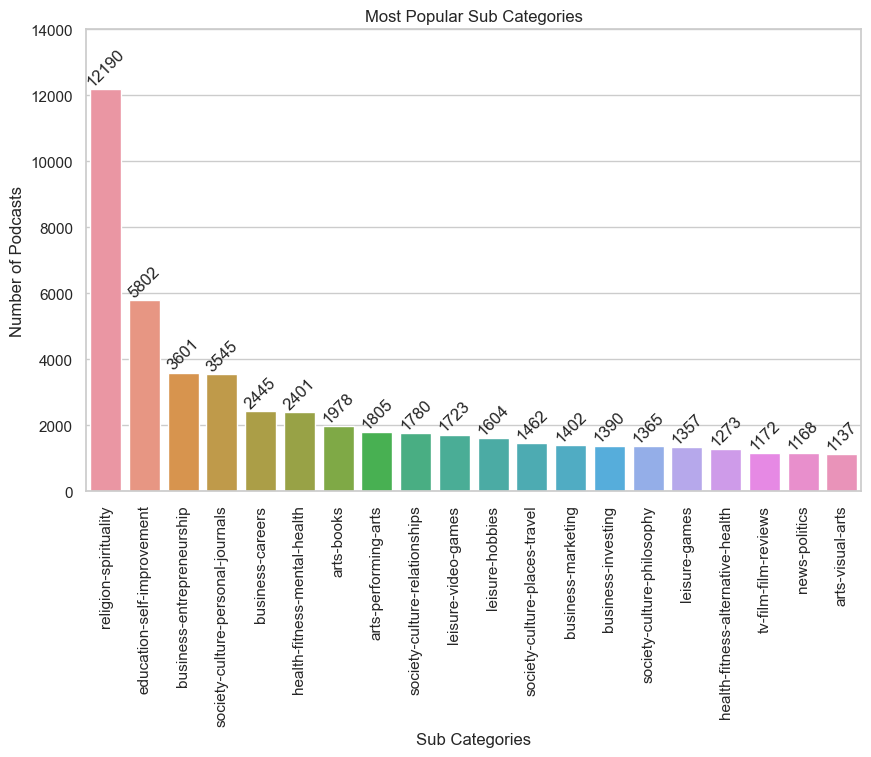

In [25]:
ax = sns.barplot(
    data=df_categories_sub.head(20), 
    x="category", 
    y="num_of_podcasts")

ax.bar_label(
    ax.containers[0], 
    rotation=45)

plt.ylim(0, 14000)
plt.xticks(rotation=90)
plt.xlabel("Sub Categories")
plt.ylabel("Number of Podcasts")
plt.title("Most Popular Sub Categories");

If we check most popular sub categories we see different distribution. Over here we see most of the popular sub category is religion spirituality which is odd, because religion as a category was not very popular. For example business is still on the top of list having different sub categories as entrepreneurship, carrers, marketing, etc.. To get better view let's also check least popular sub categories.

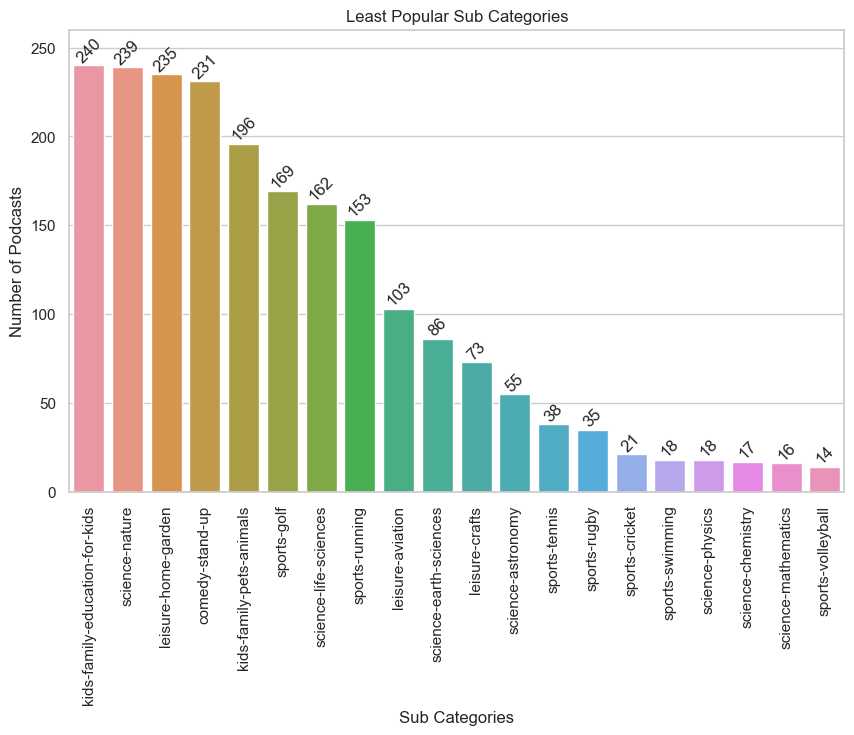

In [26]:
ax = sns.barplot(
    data=df_categories_sub.tail(20), 
    x="category", 
    y="num_of_podcasts")

ax.bar_label(
    ax.containers[0], 
    rotation=45)

plt.ylim(0, 260)
plt.xticks(rotation=90)
plt.xlabel("Sub Categories")
plt.ylabel("Number of Podcasts")
plt.title("Least Popular Sub Categories");

As we saw from first chart sport as a category was quite popular, while now as a sub category it's not very popular, we can see rugby, cricket, golf, volleyball, etc. at the end of our chart. There are not many podcasts about these sport types.

#### Podcasts Categories Summary
<ul>
    <li>We have 25 categories and 85 sub categories.</li>
    <li>From main categories we can see that we have more entertainment type podcasts, than serious ones like politics or religion.</li>
    <li>In the popular sub categories we see that religion spirituality sub category have 100 times more podcasts than category religion which is odd, so sub category is having way more podcasts than the main category it self.</li>
    <li>In least popular sub categories we found out that while sport as a category tend to have a lof of podcasts there are not many sub category sports podcasts. </li>
</ul>

### Categories popularity by rating

Next step is to find most popular categories by rating of podcasts. First we find top podcasts by review count and overall rating. To begin let's check if all podcasts have reviews.

In [27]:
df_rew_pod = sql_query("""
SELECT r.podcast_id
FROM reviews AS r
LEFT JOIN podcasts AS p
ON r.podcast_id = p.podcast_id
WHERE p.podcast_id IS NULL
""")
df_rew_pod.shape[0]

24232

We know that 24232 reviews don't have corresponding podcasts, so we work with only those podcasts which have at least one review.

In [28]:
df_cat_avg_rating = sql_query("""
SELECT
    podcasts.podcast_id, 
    title, 
    slug, 
    average_rating, 
    number_of_reviews
FROM podcasts
LEFT JOIN (
    SELECT 
        podcast_id,
        ROUND(AVG(rating), 2) AS average_rating,
        COUNT(DISTINCT author_id) AS number_of_reviews
    FROM reviews
    GROUP BY podcast_id
) AS averages
ON podcasts.podcast_id = averages.podcast_id
ORDER BY number_of_reviews DESC
""")

For our analysis 2 features will be most important - **number of reviews and rating of podcasts base by reviewers**. As both of them are integer values we can check for outliers. 

In [29]:
df_without_outliers = helpers.remove_outliers(
    df=df_cat_avg_rating, 
    column_name="number_of_reviews")

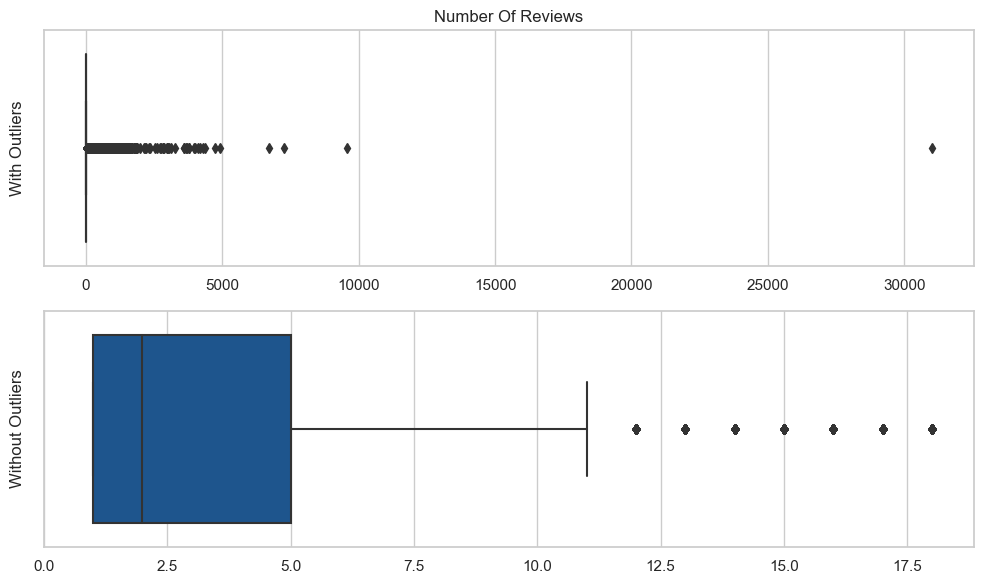

In [30]:
fig, (ax1, ax2) = plt.subplots(2, 1)

# Box plot with outliers
sns.boxplot(
    data=df_cat_avg_rating, 
    x="number_of_reviews", 
    ax=ax1)

# Box plot without outliers
sns.boxplot(
    data=df_without_outliers, 
    x="number_of_reviews", 
    ax=ax2)

ax1.set(xlabel=None)
ax2.set(xlabel=None)

ax1.set_ylabel("With Outliers")
ax2.set_ylabel("Without Outliers")

ax2.set_xlim(left=0)
ax1.set_title("Number Of Reviews")
plt.tight_layout()

In [31]:
outlier_count = df_cat_avg_rating.shape[0] - df_without_outliers.shape[0]
outlier_count

14142

#### Reviews Outliers Summary
<ul>
    <li>There are 14142 outliers.</li>
    <li>There are podcasts which have more than 1000 reviews.</li>
    <li>75% of podcasts have reviews from 1 to 11.</li>
    <li>25% of podcasts have 1 review.</li>
    <li>On average podcasts have 2 reviews.</li>
</ul>

After checking reviews number, now we can check ratings outliers.

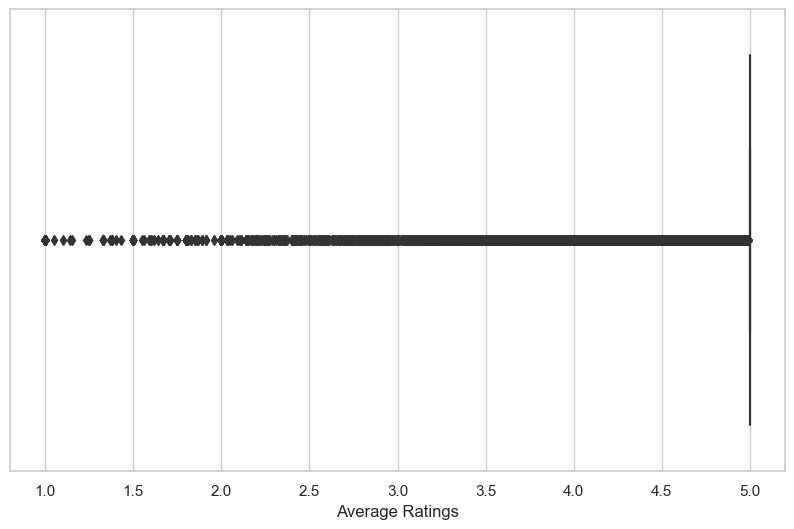

In [32]:
sns.boxplot(data=df_cat_avg_rating, x="average_rating")
plt.xlabel("Average Ratings");

#### Ratings Outliers Summary
<ul>
    <li>Ratings goes from 1 to 5.</li>
    <li>All of data sits on rating 5, giving all other ratings as outlier.</li>
    <li>Removing outliers from rating will not give any advandage as we will have only rating 5.</li>
</ul>

As we found outliers we can move forward and check categories popularity base by ratings and number of reviews for podcasts.

In [33]:
df_categories_rating = sql_query("""
SELECT 
    category,
    COUNT(category) AS num_of_reviews,
    ROUND(AVG(rating), 2) AS avg_rating
FROM categories
LEFT JOIN reviews
ON categories.podcast_id = reviews.podcast_id
GROUP BY category
ORDER BY num_of_reviews DESC
""")

In [34]:
# Pick only categories
df_categ_top_rating = df_categories_rating[
    df_categories_rating["category"].isin(unique_root_categories)]

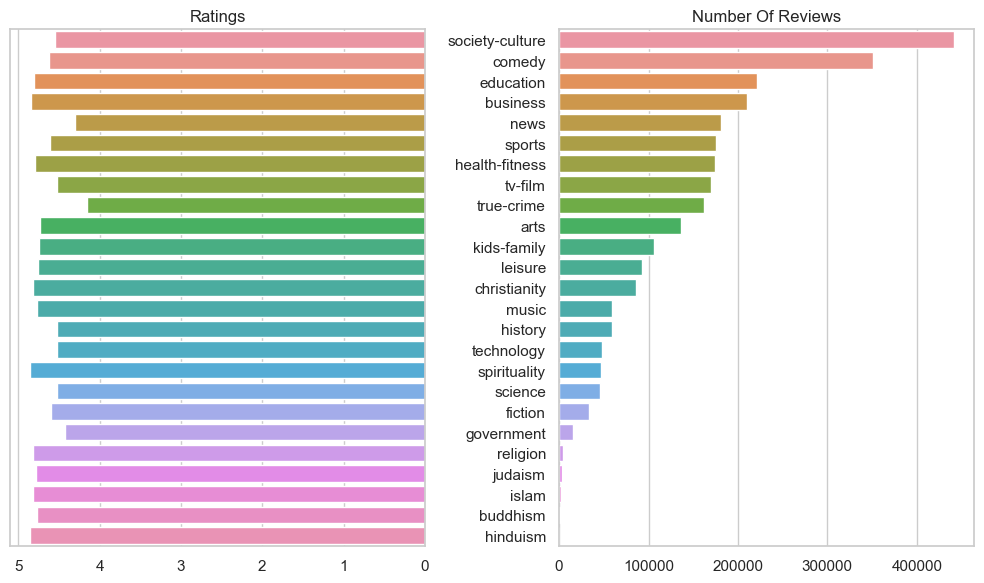

In [35]:
# Plot subplot for ratings and number of reviews
fig, (ax1, ax2) = plt.subplots(1, 2)

# Ratings
sns.barplot(
    data=df_categ_top_rating, 
    x="avg_rating", 
    y="category", 
    ax=ax1)

# Number of reviews
sns.barplot(
    data=df_categ_top_rating, 
    x="num_of_reviews", 
    y="category", 
    ax=ax2)

ax1.yaxis.set_tick_params(labelleft=False) # Remove ticks from ratings
ax1.invert_xaxis()

ax1.set(ylabel=None)
ax2.set(ylabel=None)
ax1.set(xlabel=None)
ax2.set(xlabel=None)

ax1.set_title("Ratings")
ax2.set_title("Number Of Reviews")

plt.tight_layout()

#### Podcasts Categories Rating Summary
<ul>
    <li>All main categories have similar rating going from 4 to 5.</li>
    <li>Regardless number of reviews all categories have high rating.</li>
    <li>Society culture category still remaining on first place while other entertainment categories stay on top of the charts.</li>
</ul>

### How rating changes over time

Moving one step further we can also check ratings popularity over time, through different months or years.

In [36]:
df_year_rating = sql_query("""
SELECT 
    category, 
    AVG(rating) AS avg_rating, 
    COUNT() AS number_of_reviews,
    strftime('%Y', created_at) AS year,
    strftime('%m', created_at) AS month
FROM (
    SELECT DISTINCT *
    FROM reviews AS r
    RIGHT JOIN categories AS p
    ON p.podcast_id = r.podcast_id
)
WHERE year IS NOT NULL
GROUP BY category, year, month
""")

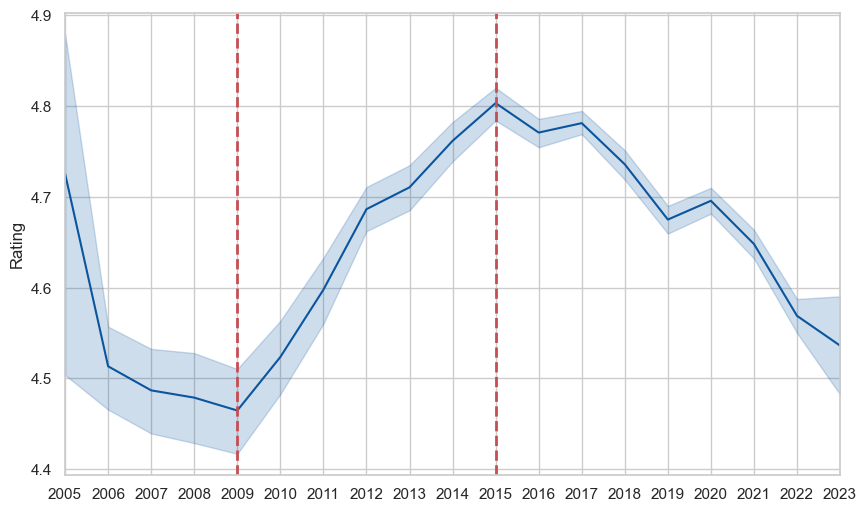

In [37]:
# Check overall rating through years
sns.lineplot(
    data=df_year_rating, 
    x="year", 
    y="avg_rating")

importand_dates = ["2009", "2015"]

for line in importand_dates:
    plt.axvline(
        x=line, 
        color='r', 
        linestyle='--', 
        linewidth=2)

plt.xlim("2005", "2023")
plt.ylabel("Rating")
plt.xlabel("");

#### Year Summary
<ul>
    <li>From 2005 till 2009 overall ratings decreasing.</li>
    <li>From 2009 until 2015 for over 8 years ratings increase.</li>
    <li>And from 2015 till 2023 ratings decrease overtime again.</li>
</ul>

Let's look closer to 2009 and 2015 years to check how ratings distributes.

In [38]:
df_2009 = df_year_rating.where(df_year_rating["year"] == "2009").dropna()
df_2015 = df_year_rating.where(df_year_rating["year"] == "2015").dropna()

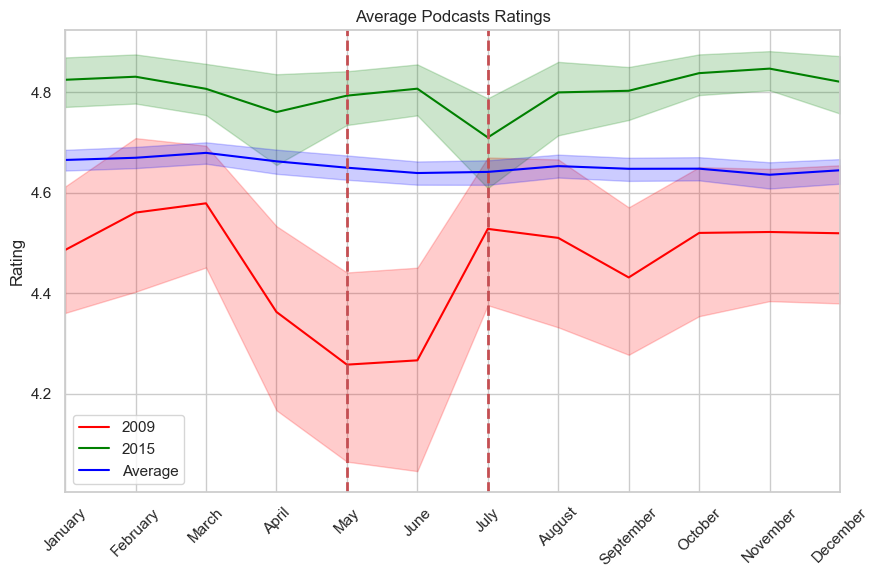

In [39]:
line_colors = ["red", "green", "blue"] # Custom colors for line plots
l_labels = ["2009", "2015", "Average"] # Custom labels 
df_line_list = [df_2009, df_2015, df_year_rating] # All lineplot dataframes

for plot in range(3):
    sns.lineplot(
    data=df_line_list[plot], 
    x="month", 
    y="avg_rating", 
    color=line_colors[plot], 
    label=l_labels[plot])


importand_months = ["05", "07"]

for line in importand_months:
    plt.axvline(
        x=line, 
        color='r', 
        linestyle='--', 
        linewidth=2)
    
plt.xticks(
    range(0, 12), 
    ['January', 'February', 'March', 
     'April', 'May', 'June', 'July', 
     'August', 'September', 'October', 
     'November', 'December'])

plt.title("Average Podcasts Ratings")
plt.xticks(rotation=45)
plt.ylabel("Rating")
plt.xlabel("")
plt.xlim(0, 11);

#### Month Summary
<ul>
    <li>If we take years averages the rating don't give any big differences. Spring have little bigger average than other seasons but difference is very small.</li>
    <li>If we take two key dates 2009 and 2015 we see bigger difference between two years.</li>
    <li>We can see that 2009 May have the lowest average rating with biggest spread over rating, while end of autumn all winter and start of spring have quite high ratings.</li>
    <li>In 2015 July have the lowest rating with biggest spread, while end of autumn all winter and start of spring have quite high ratings.</li>
</ul>

Let's find out the difference between lowest and highest ratings.

In [40]:
# Autumn end and Winter start months
high_months = ["01", "02", "03", "10", "11", "12"]

In [41]:
df_2009_lowest = df_2009.where(df_year_rating["month"] == "05").dropna()
df_2015_lowest = df_2015.where(df_year_rating["month"] == "07").dropna()
df_2009_high = df_2009.where(df_year_rating["month"].isin(high_months)).dropna()
df_2009_high = df_2015.where(df_year_rating["month"].isin(high_months)).dropna()

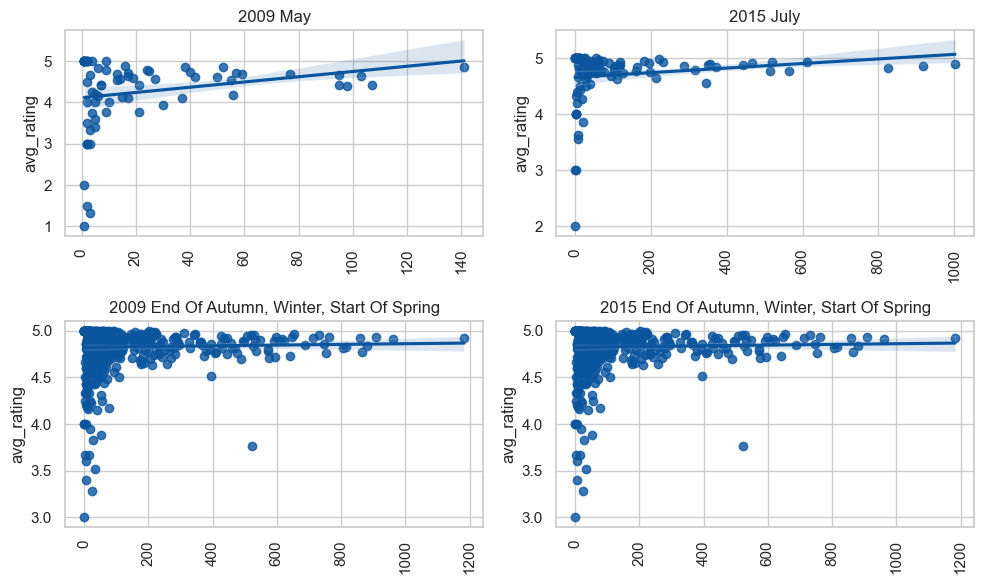

In [42]:
# Plot subplot for ratings and number of reviews
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

df_reg_list = [df_2009_lowest, df_2015_lowest, df_2009_high, df_2009_high]

axes = [ax1, ax2, ax3, ax4]  # Storing axes for easy iteration

for plot in range(4):
    sns.regplot(data=df_reg_list[plot],
                x="number_of_reviews",
                y="avg_rating",
                ax=axes[plot])

ax1.set_title("2009 May")
ax2.set_title("2015 July")
ax3.set_title("2009 End Of Autumn, Winter, Start Of Spring")
ax4.set_title("2015 End Of Autumn, Winter, Start Of Spring")

# Set x-axis tick rotation for all subplots
for ax in (ax1, ax2, ax3, ax4):
    ax.tick_params(axis='x', rotation=90)
    ax.set_xlabel("")

# Adjust layout
plt.tight_layout()

#### 2009 And 2015 Summary
<ul>
    <li>First we can see that 2015 have more than 10 times of reviews than 2009, so the rating in 2009 have higher impact on overall view.</li>
    <li>In May and July charts we see increasing trend which indicates proportional linear relationship. </li>
    <li>In Autumn and Winter charts also show correlation between ratings and reviews. But we can alse clearly see that the less reviews have podcasts the bigger spread of ratings.</li>

</ul>

## Hypothesis testing

After analyzing our dataset we can conclude some key points and form hypothesis. First of all check the mean of ratings.

<ul>
    <li>Null Hypothesis (H0): There are no difference between the mean of podcasts rating in 2009 May and the mean of 2015 July.</li>
    <li>Alternative Hypothesis (H1): There is a difference between the mean of podcasts rating in 2009 May and the mean of 2015 July.</li>
</ul>

For our hypothesis our target population will be **2009 May** and **2015 July** reviews rating.

In [43]:
df_2009_lowest_mean = round(df_2009_lowest["avg_rating"].mean(), 2)
df_2009_lowest_nobs = df_2009_lowest.shape[0]

df_2015_lowest_mean = round(df_2015_lowest["avg_rating"].mean(), 2)
df_2015_lowest_nobs = df_2015_lowest.shape[0]

print(f"2009 May \n Rating average: {df_2009_lowest_mean} \
        \n Reviews count: {df_2009_lowest_nobs}")
print(f"2015 July \n Rating average: {df_2015_lowest_mean} \
        \n Reviews count: {df_2015_lowest_nobs}")

2009 May 
 Rating average: 4.26         
 Reviews count: 72
2015 July 
 Rating average: 4.71         
 Reviews count: 103


As our size of data is quite small and also different will use [Welch's t-test](https://en.wikipedia.org/wiki/Welch%27s_t-test) and set a **95% confidence level** and check if it rejects the null hypothesis.

The α value is a treshold we will set, by which it says that the probability of observing a result as extreme or more (p-value) is lower than α, then we reject the null hypothesis. Our **α = 0.05**, so our confidence (1 - α) is 95%.

In [44]:
t_statistics, p_value = stats.ttest_ind(
    df_2009_lowest["avg_rating"], 
    df_2015_lowest["avg_rating"], 
    equal_var=False)

print(f"t_statistics: {t_statistics}")
print(f"p_value: {p_value}")

t_statistics: -3.987948558018879
p_value: 0.0001278135700698534


In [45]:
df_h1 = helpers.degrees_of_freedom(
    std1=df_2009_lowest["avg_rating"].std(), 
    std2=df_2015_lowest["avg_rating"].std(), 
    n1=df_2009_lowest["avg_rating"].shape[0], 
    n2=df_2015_lowest["avg_rating"].shape[0])

In [46]:
# Left tail
lower_cutoff = stats.t.ppf(
    q=0.025, 
    df=df_h1
)

# Right tail
upper_cutoff = stats.t.ppf(
    q=0.975, 
    df=df_h1
)
print(f"Lower cutoff: {lower_cutoff} \
        \nUpper cutoff: {upper_cutoff} \
        \nDegree of freedom {df_h1}")

Lower cutoff: -1.9842473495182043         
Upper cutoff: 1.9842473495182038         
Degree of freedom 98.87755221271492


Since the t-statistic value (-3.98..) exceeds the critical t-value (-+ 1.98..) for a significance level of 0.05 with 71 degrees of freedom. This show that the observed difference between the average ratings is unlikely to be by chance.

The p-value (0.000127) is much smaller than 0.05 which is strong evidence against the null hypothesis, so we reject the null hypothesis and accept the alternative hypothesis.

In [47]:
sigma = df_2009_lowest["avg_rating"].std()/math.sqrt(df_2009_lowest_nobs) # sample stdev/sample size
confidence_interval = stats.t.interval(
    0.95, 
    df_h1 - 1, 
    df_2009_lowest_mean, 
    scale=sigma)

confidence_interval

(4.054195698093669, 4.4658043019063305)

### 2009 May And 2015 July Means Difference Summary
The 95% confidence interval for the average rating in 2009 May, is calculated to be between 4.05 and 4.47. This means that we are 95% confident that the true average rating of the podcasts rating in 2009 May falls within this rage.
<ul>
    <li>T-statistics: -3.98..</li>
    <li>P-value: 0.00012</li>
    <li>Cutoffs: +- 1.98..</li>
</ul>

Also we can check the popularity of categories.

<ul>
    <li>Null Hypothesis (H0): There is no difference between education average rating and the business average rating.</li>
    <li>Alternative Hypothesis (H1): There is a difference between education average rating and the business average rating.</li>
</ul>

For our hypothesis our target population will be **society culture** and **religion** category reviews.

In [48]:
df_hypo_2_sc = df_year_rating.where(
    df_year_rating["category"] == "society-culture").dropna()
df_hypo_2_sc_mean = df_hypo_2_sc['avg_rating'].mean()
df_hypo_2_sc_std = df_hypo_2_sc['avg_rating'].std()
df_hypo_2_sc_nobs = df_hypo_2_sc.shape[0]

df_hypo_2_r = df_year_rating.where(
    df_year_rating["category"] == "religion").dropna()
df_hypo_2_r_mean = df_hypo_2_r['avg_rating'].mean()
df_hypo_2_r_std = df_hypo_2_r['avg_rating'].std()
df_hypo_2_r_nobs = df_hypo_2_r.shape[0]

print(f"Society culture categorie rating: {round(df_hypo_2_sc_mean, 2)} \
        \nReviews count: {df_hypo_2_sc_nobs}")
print(f"Religion categorie rating: {round(df_hypo_2_r_mean, 2)} \
        \nReviews count: {df_hypo_2_r_nobs}")

Society culture categorie rating: 4.59         
Reviews count: 207
Religion categorie rating: 4.78         
Reviews count: 167


To check if there is a statistically significant difference between the average ratings of "Society Culture" and "Religion" categories we will use a [Welch's t-test](https://en.wikipedia.org/wiki/Welch%27s_t-test) with a **95% confidence level** and check if it rejects the null hypothesis.

In [49]:
t_statistics, p_value = stats.ttest_ind_from_stats(
    mean1=df_hypo_2_sc_mean, 
    std1=df_hypo_2_sc_std, 
    nobs1=df_hypo_2_sc_nobs, 
    mean2=df_hypo_2_r_mean, 
    std2=df_hypo_2_r_std, 
    nobs2=df_hypo_2_r_nobs, 
    equal_var=False)

print(f"t_statistics: {t_statistics}")
print(f"p_value: {p_value}")

t_statistics: -5.223787363761224
p_value: 4.167748431951756e-07


In [50]:
df_h2 = helpers.degrees_of_freedom(std1=df_hypo_2_sc_std, std2=df_hypo_2_r_std, n1=df_hypo_2_sc_nobs, n2=df_hypo_2_r_nobs)

# Left tail
lower_cutoff = stats.t.ppf(
    q=0.025, 
    df=df_h2
)

# Right tail
upper_cutoff = stats.t.ppf(
    q=0.975, 
    df=df_h2
)
print(f"Lower cutoff: {lower_cutoff} \
        \nUpper cutoff: {upper_cutoff} \
        \nDegree of freedom {df_h2}")

Lower cutoff: -1.9711756650599426         
Upper cutoff: 1.9711756650599421         
Degree of freedom 212.7774574211086


As our t-statistics value (-5.22...) is way smaller than our t-value (+-1.97..) for a significance level of 0.05 with 166 degree of freedom. This show that the observed difference between the average ratings is unlikely to be by chance.

P-value (4.16..e-07) is way smaller than 0.05 which strong evidence against the null hypothesis. We can reject the null hypothesis and accept the alternative one.

In [51]:
sigma = df_hypo_2_sc_std/math.sqrt(df_hypo_2_sc_nobs) # sample stdev/sample size
confidence_interval = stats.t.interval(
    0.95, 
    df_h2-1, 
    df_hypo_2_sc_mean, 
    scale=sigma)

confidence_interval

(4.561335568228751, 4.611953869663488)

### Society Culture And Religion Category Mean Difference Summary
The 95% confidence interval for the average rating of Society Culture, is calculated to be between 4.56 and 4.61. This means that we are 95% confident that the true average rating of the Society Culture category rating falls within this range.

<ul>
    <li>T-statistics: -5.22..</li>
    <li>P-value:4.16..e-07</li>
    <li>Cutoffs: +- 1.97..</li>
    <li>We have strong evidence that Society Culture category have lower rating than Religion.</li>
</ul>

## Recommendations  

Recommendations for business.

<ul> Category
    <ul> 
        <li>Entertainment podcasts are popular than serious ones.</li>
        <li>Picking serious one like religion, science will get higher chance to get new listeners and quite stable ones.</li>
        <li>The more popular category the harder will be in the start, because people already have variety to pick from. </li>
    </ul>
    Rating
    <ul>
        <li>On average all ratings go from 4 to 5 if these number are enough picking any category is good.</li>
        <li>To get maximum ratings on average categories like: Business, Health-fitness, Christianity, Spirituality, Religion are good options in long term.</li>
    </ul>
    Date
    <ul>
        <li>To get maximum rating, podcasts are most popular in winter time.</li>
        <li>Launching podcast in summer will give lowest ratings.</li>
    </ul>

</ul>

## Suggestions For Improvement

The analysis of Podcasts Reviews can be improved in a couple of ways:

<ul>
    <li>We could check if we have any correlation between podcasts names and made some predictions.</li>
    <li>By luck we found that there are some bots who leaving reviews, we can look more useful information about them.</li>
    <li>We can look if the time of review have any impact of rating.</li>
</ul>